In [64]:
import pandas as pd
import re
import nltk
import spacy
import gensim
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import gensim.downloader as api
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from gensim import corpora
from wordcloud import WordCloud
from gensim.models import LdaMulticore
from nltk.corpus import stopwords
nltk.download('wordnet')

df = pd.read_csv('ucla_protest_tweets.csv',
                 lineterminator='\n',
                 dtype={'user_id': 'str'},
                 low_memory=False)

[nltk_data] Downloading package wordnet to /Users/peeoi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


###Exploratory Data Analysis###

In [65]:
# Inspect the data structure and data types
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18930 entries, 0 to 18929
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18930 non-null  int64  
 1   platform                  18930 non-null  object 
 2   text                      18930 non-null  object 
 3   user_id                   18930 non-null  object 
 4   total_interactions_count  18930 non-null  int64  
 5   statistics                18930 non-null  object 
 6   username                  18930 non-null  object 
 7   statuses_count            18930 non-null  float64
 8   followers_count           18930 non-null  float64
 9   friends_count             18930 non-null  float64
 10  favourites_count          18930 non-null  float64
 11  media_count               18930 non-null  float64
 12  user_description          16067 non-null  object 
 13  created_at                18930 non-null  object 
 14  profil

In [66]:
print(df['country'].value_counts())

country
United States                  10448
USA                             1933
United Kingdom                   642
Unknown                          468
Canada                           276
                               ...  
Various                            1
Saint Kitts and Nevis              1
Monaco                             1
United States and Palestine        1
France/Lebanon                     1
Name: count, Length: 161, dtype: int64


In [67]:
print(df.head())

   Unnamed: 0 platform                                               text  \
0           0  twitter  @Partisangirl I've been to several Palestinian...   
1           1  twitter  This might become my new thing. I was at the e...   
2           2  twitter  Miss last week's Working Voices on @KPFK? You ...   
3           3  twitter  #NYU #ColumbiaUniversity #Harvard #austin #fre...   
4           4  twitter  The attacks on faculty and students ramped up ...   

               user_id  total_interactions_count  \
0  1514502965804949504                         3   
1             29928441                        10   
2  1247989173866225664                         0   
3  1328600642844303360                         0   
4  1778975562964643840                         0   

                                          statistics         username  \
0  {'quote_count': 0, 'retweet_count': 0, 'like_c...  Lawrenc_Ftzgrld   
1  {'quote_count': 0, 'retweet_count': 0, 'like_c...  doloresquintana   
2  {'

In [68]:
# Combine "United States" and "USA" values in the 'country' column
df['country'] = df['country'].replace(['United States', 'USA'], 'United States')

In [69]:
# Check for missing values and handle them
print(df.isna().sum())

Unnamed: 0                      0
platform                        0
text                            0
user_id                         0
total_interactions_count        0
statistics                      0
username                        0
statuses_count                  0
followers_count                 0
friends_count                   0
favourites_count                0
media_count                     0
user_description             2863
created_at                      0
profile_url                     0
post_url                        0
location                     6710
country                      2143
country_reason               2129
country_code                 2906
account_type                  582
account_type_reason           582
media_url                   14864
dtype: int64


/Users/peeoi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


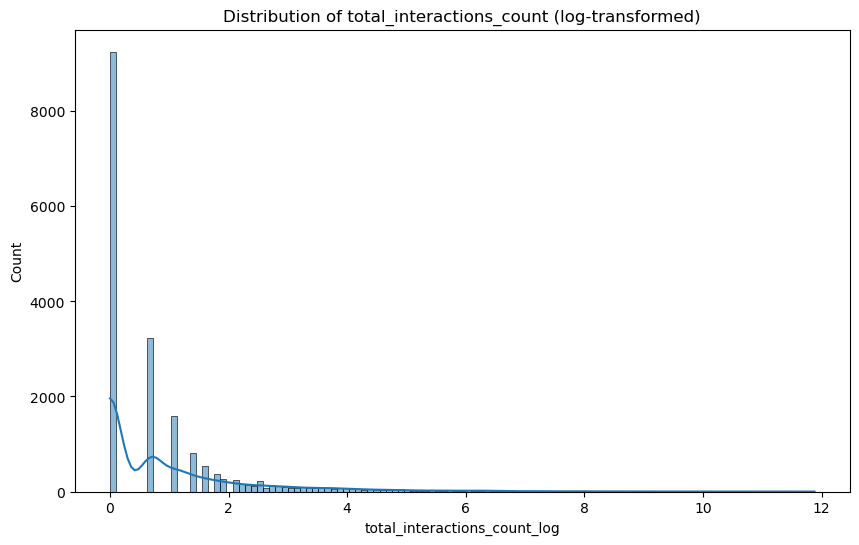

/Users/peeoi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


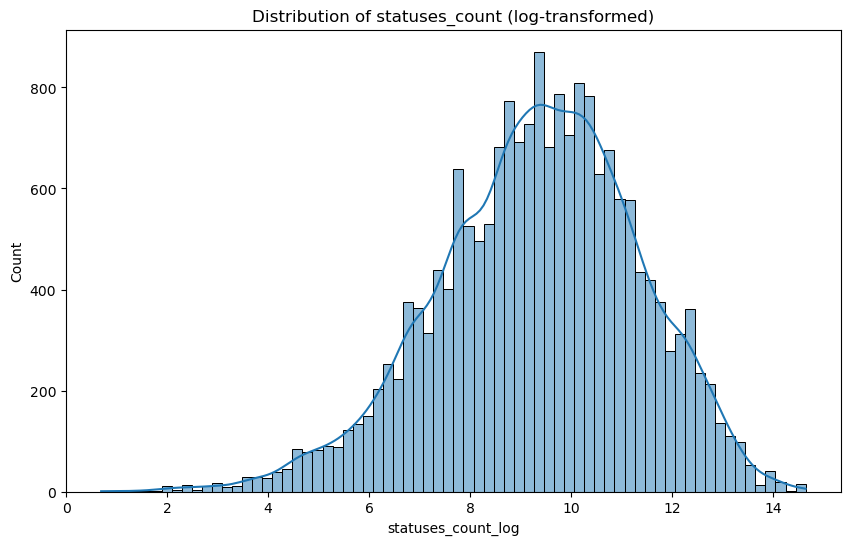

/Users/peeoi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


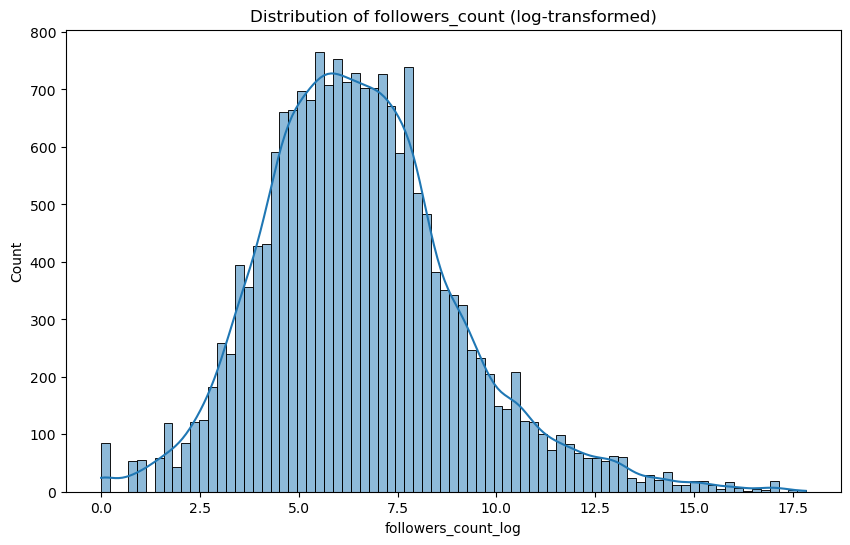

/Users/peeoi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


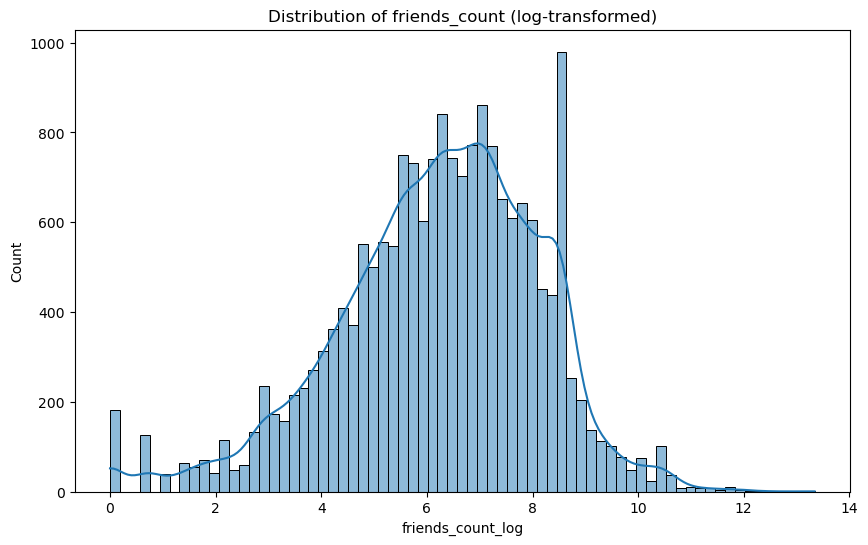

/Users/peeoi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


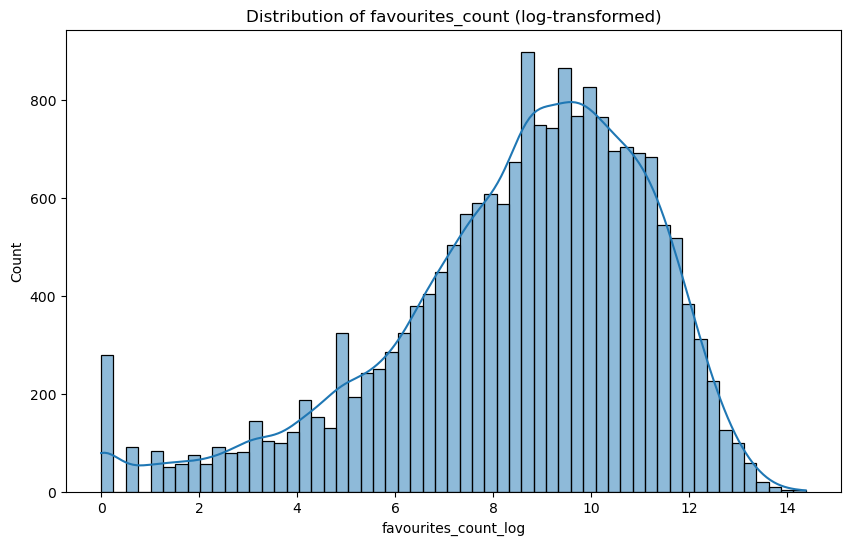

/Users/peeoi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


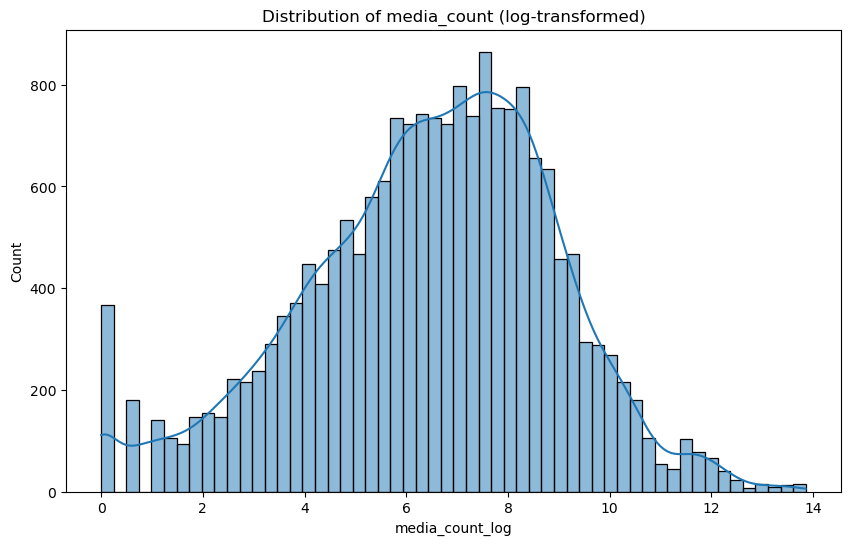

In [70]:
# Numeric feature distributions
numeric_cols = ['total_interactions_count', 'statuses_count', 'followers_count', 'friends_count', 'favourites_count', 'media_count']
for col in numeric_cols:
    df[f'{col}_log'] = np.log1p(df[col])
    plt.figure(figsize=(10, 6))
    sns.histplot(df[f'{col}_log'], kde=True)
    plt.title(f'Distribution of {col} (log-transformed)')
    plt.show()

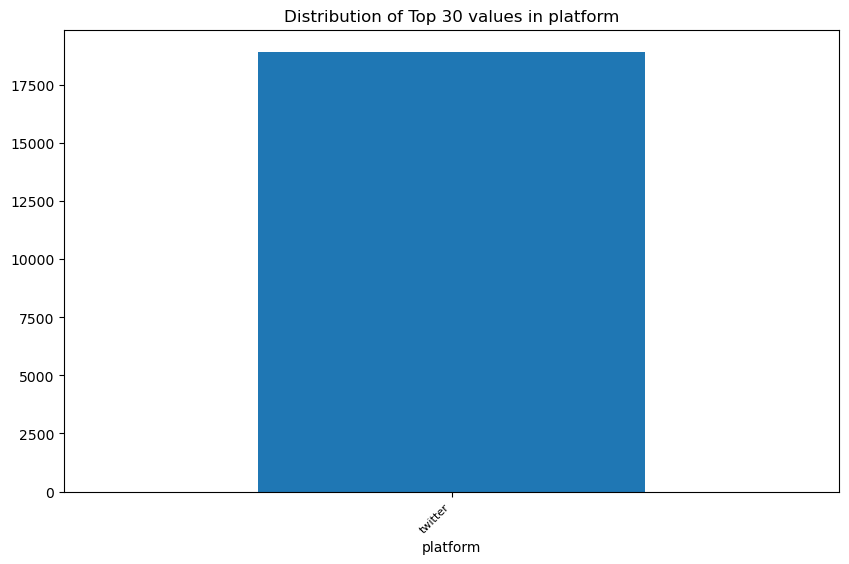

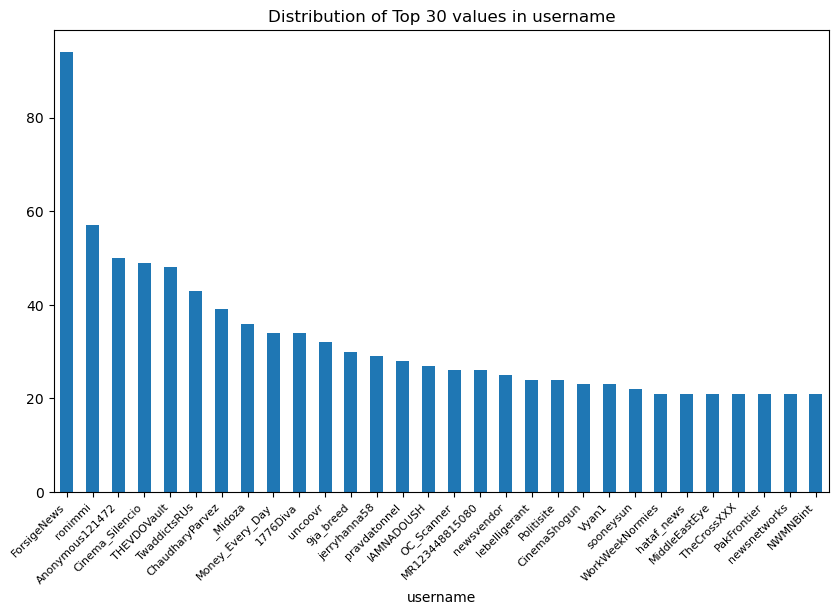

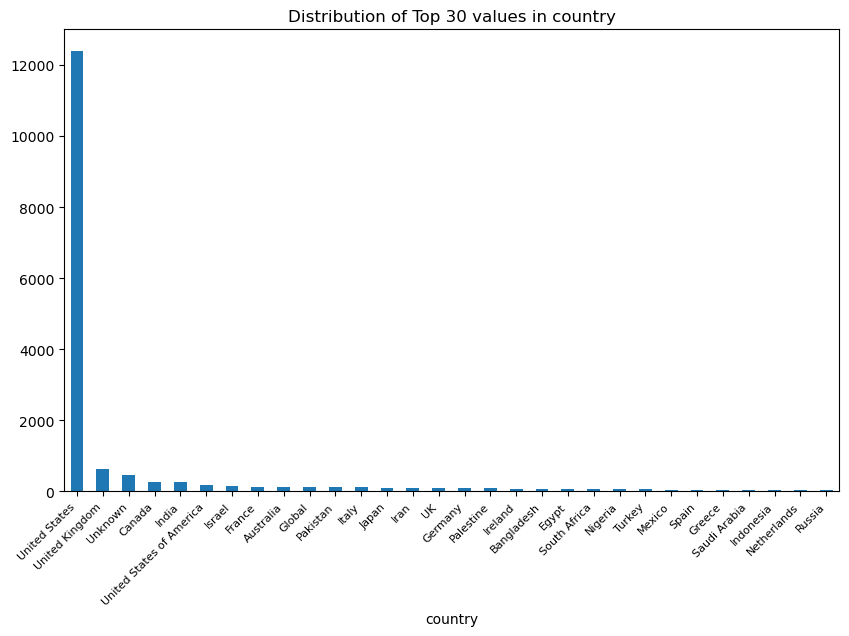

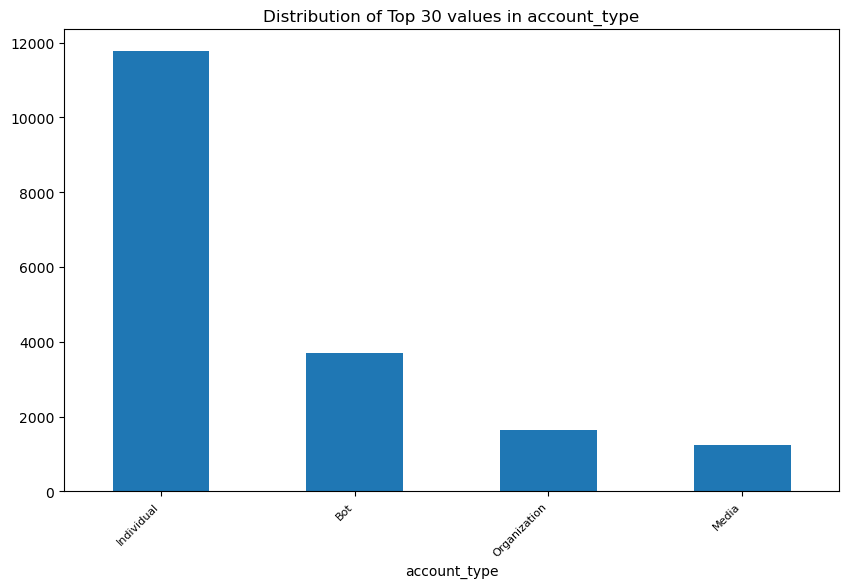

In [71]:
# Categorical feature distributions
categorical_cols = ['platform', 'username', 'country', 'account_type']
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    df[col].value_counts().nlargest(30).plot(kind='bar')
    plt.title(f'Distribution of Top 30 values in {col}')
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.show()

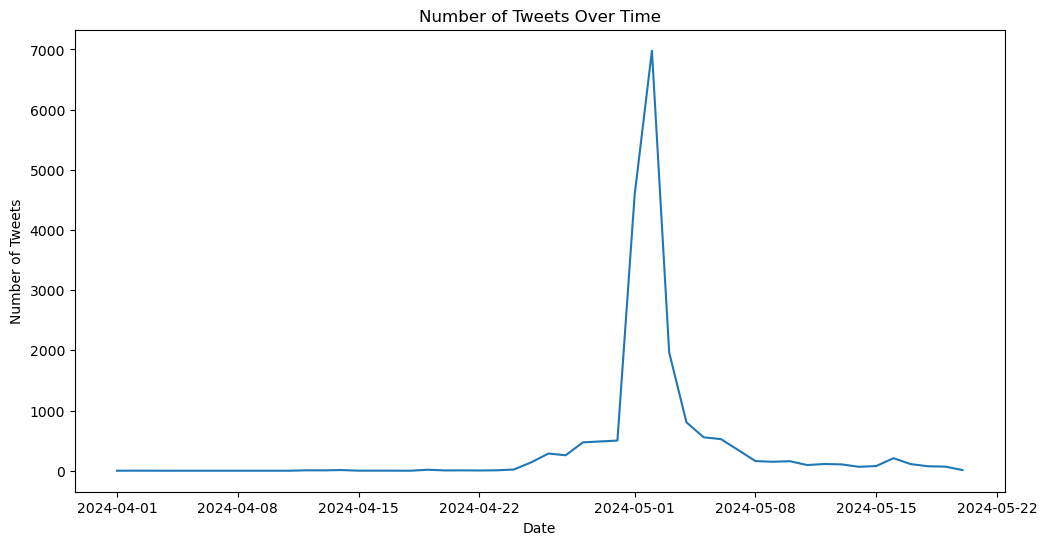

In [72]:
# Analyze the temporal aspect of the tweets
df['created_at'] = pd.to_datetime(df['created_at'])
df['date'] = df['created_at'].dt.date

# Plot the number of tweets over time
plt.figure(figsize=(12, 6))
df.groupby('date')['text'].count().plot()
plt.title('Number of Tweets Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.show()

###Identifying Narratives and Topics###

In [73]:
# Preprocess the text data
nlp = spacy.load('en_core_web_sm')

In [74]:
# Text Cleaning
def preprocess_text(text):
    # Remove URLs, mentions, and hashtags
    text = re.sub(r'https?://\S+|@\w+|#\w+', '', text)
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

df['clean_text'] = df['text'].apply(preprocess_text)

In [75]:
# Tokenization and Normalization
df['tokens'] = df['clean_text'].apply(lambda x: x.split())
stop_words = set(stopwords.words('english'))
df['normalized_tokens'] = df['tokens'].apply(lambda x: [nltk.WordNetLemmatizer().lemmatize(word) for word in x if word not in stop_words])

In [76]:
# Numerical Representation
# Bag-of-Words
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(df['clean_text'])

In [77]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])

In [78]:
# Word Embeddings (using pre-trained models)
word2vec_model = api.load('word2vec-google-news-300')
df['word_embeddings'] = df['normalized_tokens'].apply(lambda x: [word2vec_model[word] for word in x if word in word2vec_model])

In [79]:
# LDA
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics = lda_model.fit_transform(X_bow)

In [80]:
# Get the most common words for each LDA topic
n_top_words = 10
feature_names = bow_vectorizer.get_feature_names_out()
topic_words_lda = []
for topic_idx, topic in enumerate(lda_model.components_):
    topic_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1] if feature_names[i] not in stop_words]
    topic_words_lda.extend(topic_words)

In [81]:
# NMF
nmf_model = NMF(n_components=5, random_state=42)
nmf_topics = nmf_model.fit_transform(X_tfidf)

In [82]:
# Get the most common words for each NMF topic
topic_words_nmf = []
for topic_idx, topic in enumerate(nmf_model.components_):
    topic_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1] if feature_names[i] not in stop_words]
    topic_words_nmf.extend(topic_words)

In [83]:
# Count word occurrences
word_counts_lda = Counter(topic_words_lda)
word_counts_nmf = Counter(topic_words_nmf)

In [84]:
# Print the most common words and their counts
print("LDA Word Counts:")
for word, count in word_counts_lda.most_common():
    print(f"{word}: {count}")

LDA Word Counts:
ucla: 4
protests: 4
protest: 4
police: 2
student: 1
campus: 1
live: 1
encampment: 1
protesters: 1


In [85]:
# Print the most common words and their counts
print("NMF Word Counts:")
for word, count in word_counts_nmf.most_common():
    print(f"{word}: {count}")

NMF Word Counts:
ucla: 3
live: 2
protest: 2
protests: 1
columbia: 1
updates: 1
campus: 1
us: 1
college: 1
police: 1
encampment: 1
propalestinian: 1
camp: 1
gaza: 1
protester: 1
via: 1
postprotest: 1
images: 1
shocking: 1
phil: 1
dr: 1
palestine: 1


In [86]:
# Spacy-based preprocessing
nlp = spacy.load('en_core_web_sm')

def preprocess(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return tokens

df['processed_text'] = df['text'].apply(preprocess)

In [87]:
# Create the dictionary and corpus
dictionary = corpora.Dictionary(df['processed_text'])
corpus = [dictionary.doc2bow(text) for text in df['processed_text']]

In [88]:
# Train the LDA model
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=10)

print("Topics:")
for topic_idx, topic in enumerate(lda_model.print_topics(num_words=5)):
    print(f"Topic {topic_idx}: {topic}")

Topics:
Topic 0: (0, '0.054*"UCLA" + 0.051*"protest" + 0.013*"campus" + 0.011*"pro" + 0.011*"\n"')
Topic 1: (1, '0.040*"protest" + 0.033*"UCLA" + 0.017*"\n" + 0.013*"police" + 0.013*"@UCLA"')
Topic 2: (2, '0.032*"protest" + 0.025*"\n\n" + 0.025*"UCLA" + 0.020*"uclaprotest" + 0.018*"\n"')
Topic 3: (3, '0.034*"UCLA" + 0.026*"protest" + 0.019*"uclaprotest" + 0.019*"\n\n" + 0.014*" "')
Topic 4: (4, '0.042*"protest" + 0.039*"UCLA" + 0.027*"\n\n" + 0.016*"student" + 0.015*" "')
Topic 5: (5, '0.030*"protest" + 0.030*"UCLA" + 0.016*"\n\n" + 0.015*"pro" + 0.015*"student"')
Topic 6: (6, '0.045*"UCLA" + 0.036*"protest" + 0.020*"student" + 0.016*"\n" + 0.014*"campus"')
Topic 7: (7, '0.042*"protest" + 0.034*"UCLA" + 0.023*"\n" + 0.020*"\n\n" + 0.009*"@UCLA"')
Topic 8: (8, '0.039*"UCLA" + 0.028*"protest" + 0.020*"uclaprotest" + 0.017*"\n\n" + 0.011*"\n"')
Topic 9: (9, '0.080*"\n" + 0.029*"protest" + 0.025*"UCLA" + 0.022*"uclaprotest" + 0.021*"\n\n"')


In [89]:
# Combine all text into a single string
all_text = ' '.join(df['text'])

# Tokenize the text into words and remove non-alphanumeric characters and URLs
words = [re.sub(r'[^a-zA-Z0-9\s]', '', re.sub(r'https?://\S+', '', word)) for word in nltk.word_tokenize(all_text)]

# Remove stop words and the word "https"
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word.lower() not in stop_words and word.strip() != '' and word.lower() != 'https']

# Count the frequency of each word
word_counts = Counter(filtered_words)

# Remove the word "https" from the count
word_counts.pop('https', None)

Top 30 most common words:
[('UCLA', 16963), ('protest', 6394), ('protests', 6152), ('UCLAProtest', 4600), ('students', 2700), ('police', 2231), ('campus', 2147), ('encampment', 1742), ('Gaza', 1660), ('peaceful', 1566), ('Columbia', 1554), ('Israel', 1545), ('protesters', 1507), ('amp', 1414), ('nt', 1347), ('people', 1322), ('Police', 1180), ('violence', 1150), ('Palestine', 1127), ('student', 1083), ('via', 1078), ('like', 1067), ('US', 1051), ('violent', 1045), ('Protests', 960), ('Jewish', 955), ('right', 886), ('proPalestinian', 870), ('Protest', 853), ('ucla', 757)]


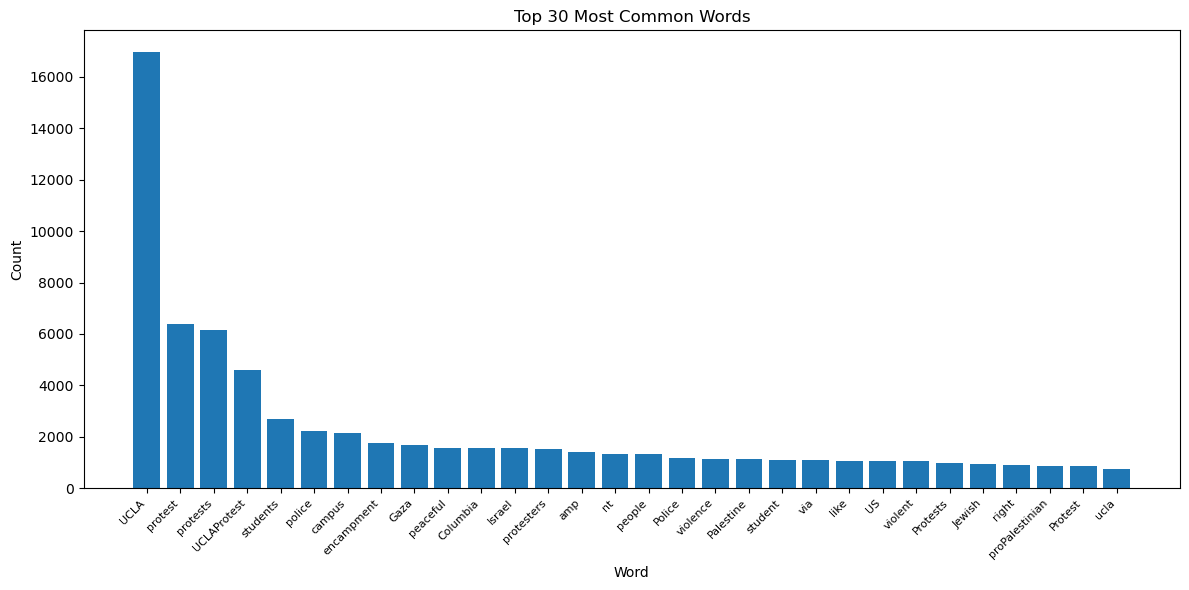

In [90]:
# Print the top 30 most common words
print("Top 30 most common words:")
print(word_counts.most_common(30))

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(range(len(word_counts.most_common(30))), [count for _, count in word_counts.most_common(30)], align='center')
plt.xticks(range(len(word_counts.most_common(30))), [word for word, _ in word_counts.most_common(30)], rotation=45, fontsize=8, ha='right')
plt.title("Top 30 Most Common Words")
plt.xlabel("Word")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

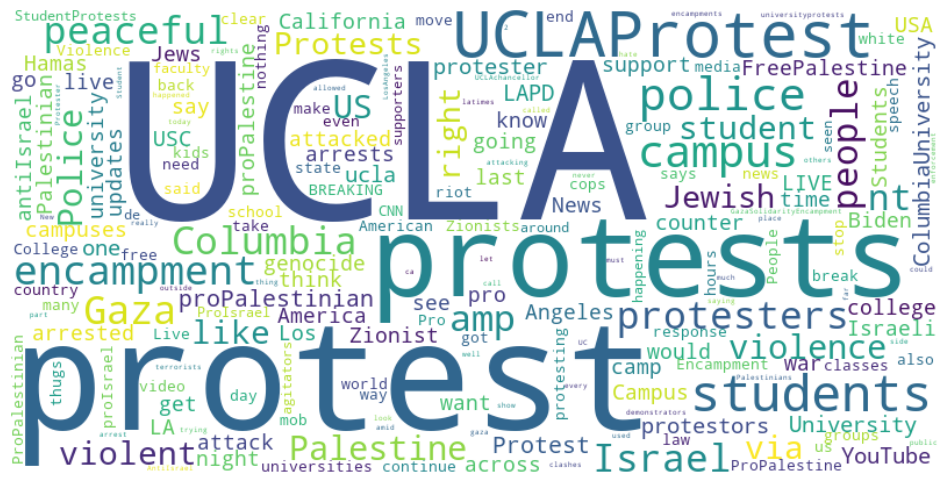

In [91]:
# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [92]:
# Counts Top 10 Country
country_counts = df['country_code'].value_counts()
top_10_countries = country_counts.head(10)
print(top_10_countries)

country_code
us    12550
gb      655
ca      276
in      273
il      143
fr      132
au      129
pk      123
it      121
jp      101
Name: count, dtype: int64


In [93]:
us_tweets = df[df['country'] == 'United States']
other_tweets = df[df['country'] != 'United States']

In [94]:
us_tweet_dates = pd.to_datetime(us_tweets['created_at'])
other_tweet_dates = pd.to_datetime(other_tweets['created_at'])

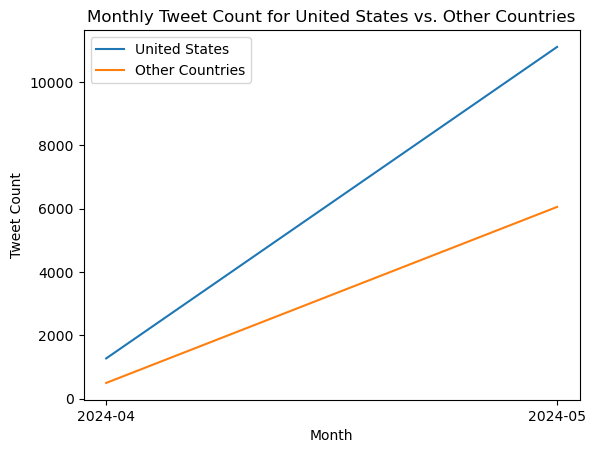

In [95]:
us_tweet_monthly_counts = us_tweet_dates.groupby(us_tweet_dates.dt.to_period('M')).count()
us_tweet_monthly_counts.index = us_tweet_monthly_counts.index.astype(str)

other_tweet_monthly_counts = other_tweet_dates.groupby(other_tweet_dates.dt.to_period('M')).count()
other_tweet_monthly_counts.index = other_tweet_monthly_counts.index.astype(str)

plt.plot(us_tweet_monthly_counts.index, us_tweet_monthly_counts.values, label='United States')
plt.plot(other_tweet_monthly_counts.index, other_tweet_monthly_counts.values, label='Other Countries')
plt.xlabel('Month')
plt.ylabel('Tweet Count')
plt.title('Monthly Tweet Count for United States vs. Other Countries')
plt.legend()
plt.show()

In [96]:
# Top users by total interactions
top_users = df.groupby('username')['total_interactions_count'].sum().sort_values(ascending=False).head(10)
print(top_users)

# User engagement metrics
df['engagement_rate'] = df['total_interactions_count'] / df['followers_count']
print(df.groupby('username')['engagement_rate'].mean().sort_values(ascending=False).head(10))

username
Kahlissee          144715
FilmThePoliceLA     57515
realCWhitehouse     39286
umichvoter          34192
MarinaMedvin        32345
CollinRugg          29498
_ClaraHarter        28824
EndWokeness         27980
KyungLahCNN         23248
BillAckman          20379
Name: total_interactions_count, dtype: int64
username
RGhofranian        inf
TRhodes94161       inf
dempseyodwyer      inf
b1_basar           inf
bigflexxxin        inf
strivefor_peace    inf
fightnightextra    inf
aygithub           inf
annie61382         inf
AAbuqassem96952    inf
Name: engagement_rate, dtype: float64


In [97]:
df.columns

Index(['Unnamed: 0', 'platform', 'text', 'user_id', 'total_interactions_count',
       'statistics', 'username', 'statuses_count', 'followers_count',
       'friends_count', 'favourites_count', 'media_count', 'user_description',
       'created_at', 'profile_url', 'post_url', 'location', 'country',
       'country_reason', 'country_code', 'account_type', 'account_type_reason',
       'media_url', 'total_interactions_count_log', 'statuses_count_log',
       'followers_count_log', 'friends_count_log', 'favourites_count_log',
       'media_count_log', 'date', 'clean_text', 'tokens', 'normalized_tokens',
       'word_embeddings', 'processed_text', 'engagement_rate'],
      dtype='object')

###Key Opinion Leaders###

In [98]:
# Identify key opinion leaders based on engagement rate and follower count
print("Identifying Key Opinion Leaders:")

# Calculate the engagement rate percentile for each user
if 'engagement_rate' in df.columns:
    df['engagement_rate_percentile'] = df['engagement_rate'].rank(method='dense', pct=True)
else:
    print("'engagement_rate' column not found in the dataset.")

# Calculate the follower count percentile for each user
if 'followers_count' in df.columns:
    df['followers_count_percentile'] = df['followers_count'].rank(method='dense', pct=True)
else:
    print("'followers_count' column not found in the dataset.")

# Identify users who are in the top 20% for both engagement rate and follower count
if 'engagement_rate_percentile' in df.columns and 'followers_count_percentile' in df.columns:
    key_opinion_leaders = df[(df['engagement_rate_percentile'] >= 0.8) & (df['followers_count_percentile'] >= 0.8)]

    if not key_opinion_leaders.empty:
        print("All Key Opinion Leaders:")
        print(key_opinion_leaders[['username', 'engagement_rate', 'followers_count']])
        
        print("\nTop 10 Key Opinion Leaders:")
        print(key_opinion_leaders[['username', 'engagement_rate', 'followers_count']].sort_values(by='followers_count', ascending=False).head(10))
    else:
        print("No key opinion leaders identified based on the given criteria.")
else:
    print("Insufficient data to identify key opinion leaders.")

Identifying Key Opinion Leaders:
All Key Opinion Leaders:
              username  engagement_rate  followers_count
181         paulbiggar         0.020284          29136.0
326    FilmThePoliceLA         0.034499          69307.0
469        KyungLahCNN         0.338074          68766.0
472       _NicoleNonya         0.035680          54288.0
603    FilmThePoliceLA         0.148686          69307.0
...                ...              ...              ...
18007  SabrinaSmolders         0.022989          27492.0
18261           utism_         0.034562          29917.0
18396     MarinaMedvin         0.120124         269264.0
18408           AFpost         0.032223          38854.0
18673    persianjewess         0.191210          48418.0

[67 rows x 3 columns]

Top 10 Key Opinion Leaders:
             username  engagement_rate  followers_count
3571       BillAckman         0.015945        1278102.0
1984       CollinRugg         0.026444        1115501.0
16841   MaxBlumenthal         0.014160

###User Characterization###

In [99]:
# Analyze user account types
print(df['account_type'].value_counts())

# Examine user location and country distribution
print(df['country'].value_counts())
print(df.groupby('country')['text'].count())

# Investigate user engagement metrics
print(df['total_interactions_count'].describe())
print(df['engagement_rate'].describe())

account_type
Individual      11767
Bot              3689
Organization     1647
Media            1245
Name: count, dtype: int64
country
United States               12381
United Kingdom                642
Unknown                       468
Canada                        276
India                         273
                            ...  
Eurozone                        1
Saint Kitts and Nevis           1
Monaco                          1
Guyana                          1
Islamic Republic of Iran        1
Name: count, Length: 160, dtype: int64
country
Afghanistan     4
Africa          2
Albania         1
Algeria         3
Argentina      14
               ..
Various         1
Vietnam         2
Wales           1
Worldwide      12
Yemen          12
Name: text, Length: 160, dtype: int64
count     18930.000000
mean         56.182937
std        1304.358807
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max      144715.000000
Name: total_interactions

/Users/peeoi/anaconda3/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [100]:
# Identify influential users
top_users = df.nlargest(10, 'total_interactions_count')
print(top_users[['username', 'total_interactions_count']])

# Explore user networks
user_graph = nx.Graph()

for i, row in df.iterrows():
    user_graph.add_node(row['user_id'], **row)
    
    # Check the data type of the 'statistics' column
    if isinstance(row['statistics'], str):
        try:
            # Assuming the 'statistics' column is a JSON string, parse it
            import json
            statistics = json.loads(row['statistics'])
            for mention in statistics['user_mentions']:
                user_graph.add_edge(row['user_id'], mention['id_str'])
        except (ValueError, KeyError):
            # Handle cases where the 'statistics' column is not in the expected format
            pass


              username  total_interactions_count
7821         Kahlissee                    144715
18625  realCWhitehouse                     39286
4594        umichvoter                     34192
18396     MarinaMedvin                     32345
1668   FilmThePoliceLA                     32339
1984        CollinRugg                     29498
12528     _ClaraHarter                     28782
2793       EndWokeness                     27980
469        KyungLahCNN                     23248
3571        BillAckman                     20379


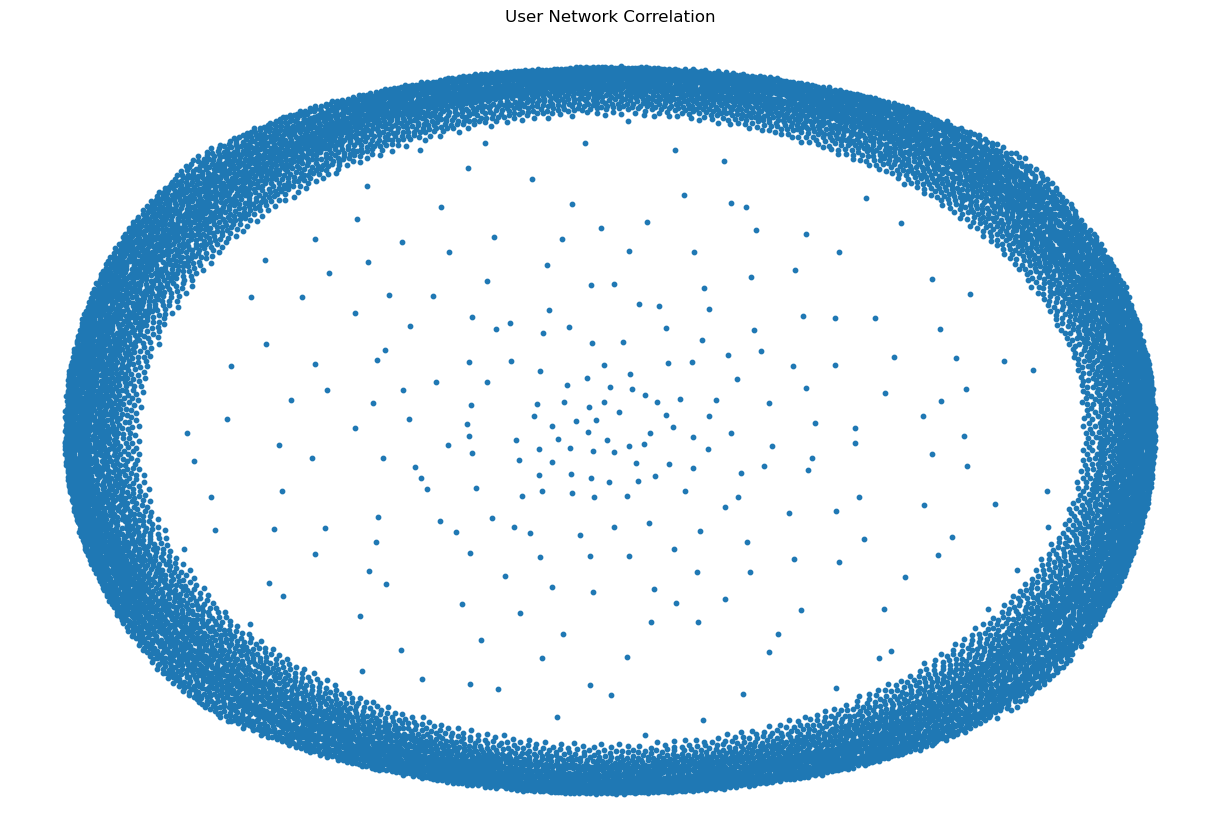

In [101]:
# Visualize the user network
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(user_graph)
nx.draw(user_graph, pos, with_labels=False, node_size=10)
plt.title("User Network Correlation")
plt.show()

###Assessing Potential Disinformation###

In [102]:
# Check the input DataFrame
print(df.head())
print(df.info())

   Unnamed: 0 platform                                               text  \
0           0  twitter  @Partisangirl I've been to several Palestinian...   
1           1  twitter  This might become my new thing. I was at the e...   
2           2  twitter  Miss last week's Working Voices on @KPFK? You ...   
3           3  twitter  #NYU #ColumbiaUniversity #Harvard #austin #fre...   
4           4  twitter  The attacks on faculty and students ramped up ...   

               user_id  total_interactions_count  \
0  1514502965804949504                         3   
1             29928441                        10   
2  1247989173866225664                         0   
3  1328600642844303360                         0   
4  1778975562964643840                         0   

                                          statistics         username  \
0  {'quote_count': 0, 'retweet_count': 0, 'like_c...  Lawrenc_Ftzgrld   
1  {'quote_count': 0, 'retweet_count': 0, 'like_c...  doloresquintana   
2  {'

In [103]:
# Identify potentially suspicious accounts
suspicious_accounts = df[(df['account_type'] == 'bot') | (df['account_type'] == 'suspicious')]
print(suspicious_accounts[['username', 'account_type', 'total_interactions_count']])

Empty DataFrame
Columns: [username, account_type, total_interactions_count]
Index: []


In [104]:
# Analyze content for signs of disinformation
# Load the spacy model
nlp = spacy.load("en_core_web_sm")

def detect_disinformation(text):
    try:
        if isinstance(text, list):
            text = ' '.join(text)
        doc = nlp(text)
        entities = [e.label_ for e in doc.ents]
        entity_types = Counter(entities)
        
        # Heuristics for detecting potential disinformation
        if 'ORG' in entity_types and entity_types['ORG'] > 2:
            return 'Potential organizational coordination'
        if 'GPE' in entity_types and entity_types['GPE'] > 3:
            return 'Potential geographical manipulation'
        if 'PERSON' in entity_types and entity_types['PERSON'] > 5:
            return 'Potential identity deception'
        
        return 'No obvious signs of disinformation'
    
    except Exception as e:
        print(f"Error processing text: {e}")
        return 'Error processing text'

df['disinformation_assessment'] = df['processed_text'].apply(detect_disinformation)
print(df['disinformation_assessment'].value_counts())

disinformation_assessment
No obvious signs of disinformation       17174
Potential organizational coordination     1596
Potential geographical manipulation        155
Potential identity deception                 5
Name: count, dtype: int64


In [105]:
# Summarize user characteristics
print("User Characteristics:")
print(df['account_type'].value_counts())
print(df.groupby('country')['text'].count())
print(df['total_interactions_count'].describe())
print(df['engagement_rate'].describe())


User Characteristics:
account_type
Individual      11767
Bot              3689
Organization     1647
Media            1245
Name: count, dtype: int64
country
Afghanistan     4
Africa          2
Albania         1
Algeria         3
Argentina      14
               ..
Various         1
Vietnam         2
Wales           1
Worldwide      12
Yemen          12
Name: text, Length: 160, dtype: int64
count     18930.000000
mean         56.182937
std        1304.358807
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max      144715.000000
Name: total_interactions_count, dtype: float64
count    1.887300e+04
mean              inf
std               NaN
min      0.000000e+00
25%      0.000000e+00
50%      1.284117e-05
75%      3.215434e-03
max               inf
Name: engagement_rate, dtype: float64


/Users/peeoi/anaconda3/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [106]:
# Identify top influential users
top_users = df.nlargest(10, 'total_interactions_count')
print("\nTop 10 Influential Users:")
print(top_users[['username', 'total_interactions_count']])



Top 10 Influential Users:
              username  total_interactions_count
7821         Kahlissee                    144715
18625  realCWhitehouse                     39286
4594        umichvoter                     34192
18396     MarinaMedvin                     32345
1668   FilmThePoliceLA                     32339
1984        CollinRugg                     29498
12528     _ClaraHarter                     28782
2793       EndWokeness                     27980
469        KyungLahCNN                     23248
3571        BillAckman                     20379


###Reporting and Interpretation###

In [107]:
# Overall summary
print("Dataset summary:")
print(df.info())
print(df.describe())

Dataset summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18930 entries, 0 to 18929
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Unnamed: 0                    18930 non-null  int64         
 1   platform                      18930 non-null  object        
 2   text                          18930 non-null  object        
 3   user_id                       18930 non-null  object        
 4   total_interactions_count      18930 non-null  int64         
 5   statistics                    18930 non-null  object        
 6   username                      18930 non-null  object        
 7   statuses_count                18930 non-null  float64       
 8   followers_count               18930 non-null  float64       
 9   friends_count                 18930 non-null  float64       
 10  favourites_count              18930 non-null  float64       
 11  media_count

/Users/peeoi/anaconda3/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [108]:
# Engagement analysis
print("\nEngagement analysis:")
print(f"Average engagement rate: {df['engagement_rate'].mean():.2f}")
top_engaging_posts = df.nlargest(10, 'engagement_rate')
print("\nTop 10 most engaging posts:")
print(top_engaging_posts[['text', 'engagement_rate']])



Engagement analysis:
Average engagement rate: inf

Top 10 most engaging posts:
                                                   text  engagement_rate
103   @Zimmlaw175 I think Jeffrey is confused.  The ...              inf
709   @BobMann2001 @jduffyrice @SnowFairyToo @fred_g...              inf
1440  The UCLA African American Studies Department e...              inf
2059  @FilmThePoliceLA UCLA cops and the sheriff are...              inf
3259  American students the whole world witnessing y...              inf
3388  @DrLoupis @UCLA They are lawbreakers, disrespe...              inf
5612  @Molsen68 @mihaschw @UCLA Your point?  Student...              inf
6216  @OliLondonTV @LauraPowellEsq More like UCLA pr...              inf
6324  'They want the killing to stop': James O'Brien...              inf
6856  Why Palestinians can count on American student...              inf



Geographical analysis:
Number of unique countries: 160

Top 30 Countries:
country
United States               12381
United Kingdom                642
Unknown                       468
Canada                        276
India                         273
United States of America      165
Israel                        143
France                        132
Australia                     129
Global                        124
Pakistan                      123
Italy                         121
Japan                         101
Iran                          100
UK                             96
Germany                        86
Palestine                      83
Ireland                        75
Bangladesh                     71
Egypt                          68
South Africa                   67
Nigeria                        67
Turkey                         57
Mexico                         49
Spain                          49
Greece                         42
Saudi Arabia                   34

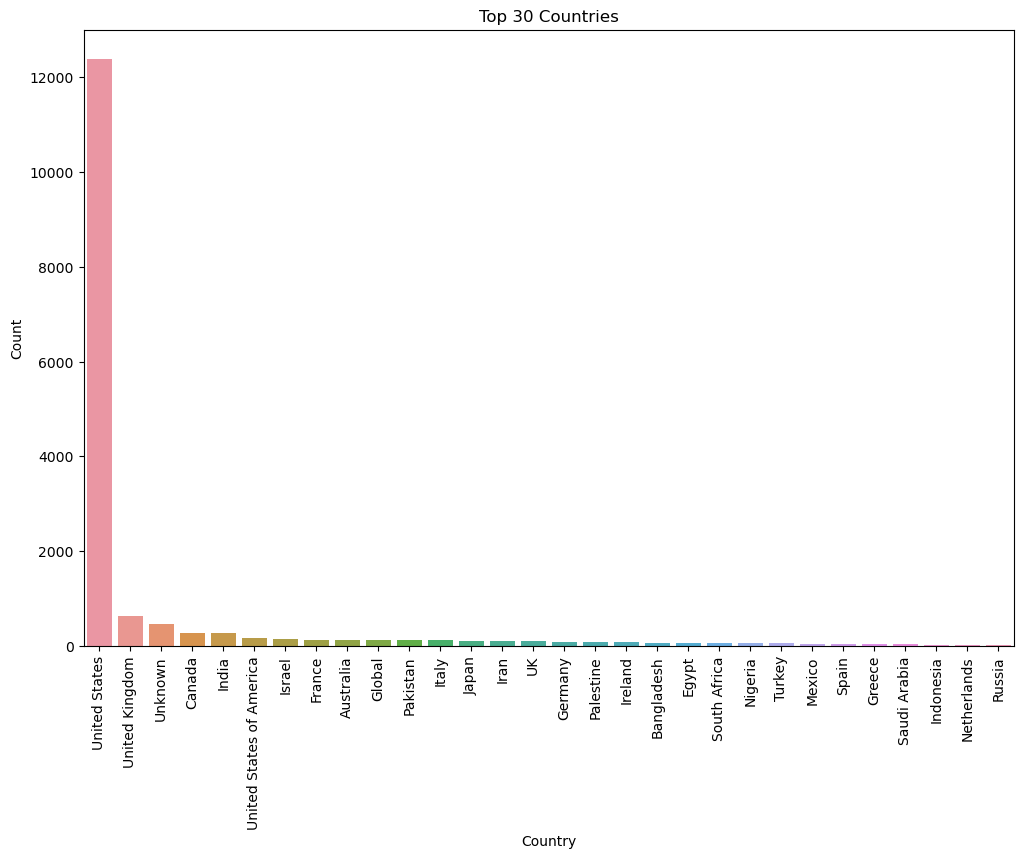

In [109]:
# Geographical analysis
print("\nGeographical analysis:")
print(f"Number of unique countries: {df['country'].nunique()}")
top_countries = df['country'].value_counts().head(30)
print("\nTop 30 Countries:")
print(top_countries)
plt.figure(figsize=(12, 8))
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.xticks(rotation=90)
plt.title('Top 30 Countries')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

In [110]:
# Account type analysis
print("\nAccount type analysis:")
print(df['account_type'].value_counts())


Account type analysis:
account_type
Individual      11767
Bot              3689
Organization     1647
Media            1245
Name: count, dtype: int64



Account age analysis:
Average account age: 43 days


/Users/peeoi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


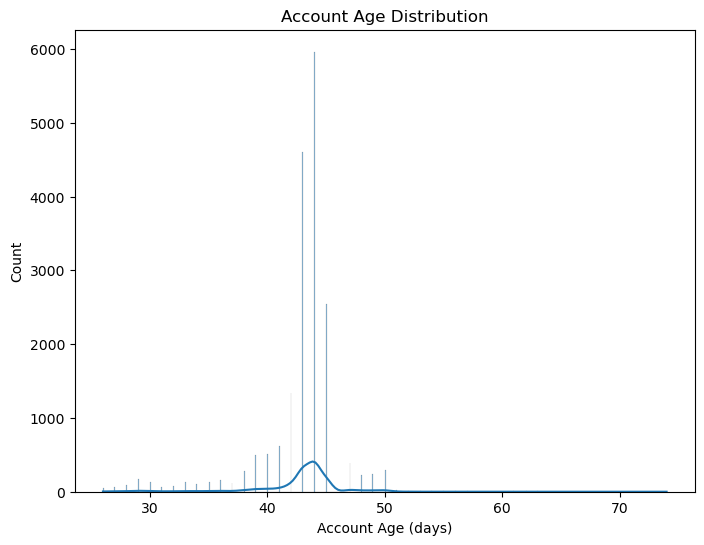

In [111]:
# Account age analysis
print("\nAccount age analysis:")
df['account_age'] = (pd.to_datetime('today') - pd.to_datetime(df['created_at'])).dt.days
print(f"Average account age: {df['account_age'].mean():.0f} days")
plt.figure(figsize=(8, 6))
sns.histplot(df['account_age'], kde=True)
plt.title('Account Age Distribution')
plt.xlabel('Account Age (days)')
plt.show()


In [112]:
# Disinformation assessment
print("\nDisinformation assessment:")
print(df['disinformation_assessment'].value_counts())


Disinformation assessment:
disinformation_assessment
No obvious signs of disinformation       17174
Potential organizational coordination     1596
Potential geographical manipulation        155
Potential identity deception                 5
Name: count, dtype: int64
